## PSD+SVM Method

In [1]:
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

from helper_functions import *
from latency_helpers import *
from loading_functions import *
from file_paths import *
from models import *
import importlib


import random

In [2]:
import importlib
import loading_functions
importlib.reload(loading_functions)
from loading_functions import *

### Load Features

In [3]:
feat_name = 'PSD'
t_seg = 20 #ms
n_per_seg = 1024
interferences = ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
output_name = 'drones'
feat_format = 'ARR'
which_dataset = 'dronedetect'
output_tensor = False

if which_dataset == 'dronerf':
    print('Loading DroneRF Dataset')
    highlow = 'L'
    dataset = DroneRFTorch(dronerf_feat_path, feat_name, t_seg, n_per_seg,
                       feat_format, output_name, output_tensor, highlow)
elif which_dataset == 'dronedetect':
    print('Loading DroneDetect Dataset')
    dataset = DroneDetectTorch(dronedetect_feat_path, feat_name, t_seg, n_per_seg, feat_format,
                                    output_name, output_tensor, interferences)
X_use, y_use = dataset.get_arrays()

# Set fixed number of samples
# n_samps = 15500
# i_test= random.sample(range(len(dataset)), n_samps)
# # i_test= list(range(0,2712,10))
# X_use, y_use = dataset.__getitem__(i_test)
print(X_use.shape)

Loading DroneDetect Dataset
Directory Name:  /home/kzhou/main/Features/ARR_PSD_1024_20/
dataset size 38978
shape of each item (1024,)
(38978, 1024)


### Run Model

In [4]:
model = PsdSVM(t_seg, n_per_seg)

1it [03:53, 233.12s/it]

Fold 1: Accuracy: 0.848,	 F1: 0.845, 	 Runtime: 0.00992


2it [07:48, 234.43s/it]

Fold 2: Accuracy: 0.852,	 F1: 0.85, 	 Runtime: 0.00989


3it [11:46, 236.24s/it]

Fold 3: Accuracy: 0.856,	 F1: 0.853, 	 Runtime: 0.0101


4it [15:43, 236.34s/it]

Fold 4: Accuracy: 0.863,	 F1: 0.861, 	 Runtime: 0.00992


5it [19:39, 235.81s/it]

Fold 5: Accuracy: 0.849,	 F1: 0.847, 	 Runtime: 0.00995
PSD+SVM 5 Fold CV acc: 0.854, F1: 0.851, Run-time: 9.96ms


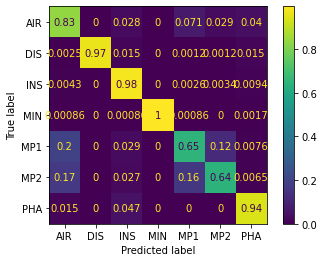

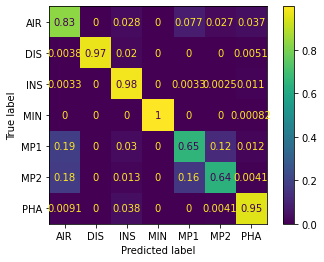

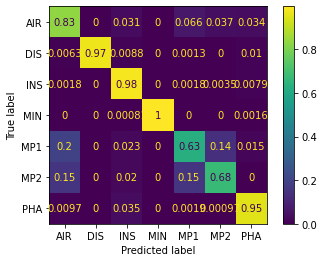

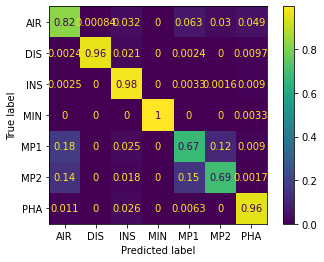

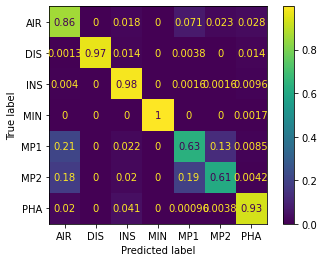

In [5]:
accs, f1s, runts = model.run_cv(X_use, y_use, k_fold=5)

In [7]:
for icv in range(5):
    print(model.cv_models[icv].support_vectors_.shape)

(12345, 1024)
(12395, 1024)
(12450, 1024)
(12469, 1024)
(12383, 1024)


In [8]:
np.mean([12345,12395,12450,12469,12383])

12408.4

In [ ]:
# search through parameters
Cs=list(map(lambda x:pow(2,x),range(-3,10,2)))
gammas=list(map(lambda x:pow(2,x),range(-3,10,2)))
parameters = {'C':Cs, 'gamma':gammas}

k_fold=5

accs, f1s, runts, best_params = model.run_gridsearch(X_use, y_use, parameters, k_fold)

### Visualize Results

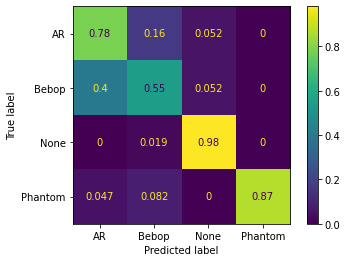

In [14]:
# Set-up train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_use, 
                                                    y_use, 
                                                    test_size=0.33, 
                                                    random_state=None)

# Train & Test
model.train(X_train, y_train)
preds = model.predict(X_test)
show_confusion_matrix(y_test, preds)

### Save Model

In [10]:
to_train_all = True # whether to retrain using all the data
model_name = which_dataset+'_'+'SVM'+'_'+str(feat_name)+'_'+str(n_per_seg)+'_'+str(t_seg)+'_'+str(int(to_train_all))
model_path = '../temp_figs/'

if to_train_all:
    model.train(X_use, y_use)

model.save(model_path, model_name)

# pickle.dump(svc, open(model_path+model_name, 'wb'))

Model saved as: ../temp_figs/SVM_PSD_1024_20_1


-----------------

In [3]:
# import loading_functions
# importlib.reload(loading_functions)
# from loading_functions import *

## Pilot Test- Try Model on GamutRF data

In [2]:
data_path = '/home/kzhou/Data/S3/leesburg_worker1/Features/'
Xgamut = load_gamut_features(data_path, 'psd')

100%|███████████████████████████████████████| 115/115 [00:00<00:00, 2255.41it/s]


In [7]:
# normalize data
## Apply normalization
X_gamut_norm = Xgamut
for n in range(len(Xgamut)):
    X_gamut_norm[n] = Xgamut[n]/max(Xgamut[n])

X_gamut_norm.max()

1.0

In [8]:
# Feed data through trained SVM model
y_gamut_pred = model.predict(X_gamut_norm)

In [9]:
y_gamut_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,